<a href="https://colab.research.google.com/github/BrunoRobertoGoncalves/EyeCancerSurvivalEstimator/blob/main/Eye_Cancer_Survival_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Process


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set(style="whitegrid")

uploaded = files.upload()

df = pd.read_csv('eye_cancer_patients.csv')
df.head()


Saving eye_cancer_patients.csv to eye_cancer_patients (2).csv


,Patient_ID,Age,Gender,Cancer_Type,Laterality,Date_of_Diagnosis,Stage_at_Diagnosis,Treatment_Type,Surgery_Status,Radiation_Therapy,Chemotherapy,Outcome_Status,Survival_Time_Months,Genetic_Markers,Family_History,Country
0,PID00001,58,F,Retinoblastoma,Left,2019-01-25,Stage IV,Radiation,False,15,3,Deceased,85,NaN,True,UK
1,PID00002,15,Other,Retinoblastoma,Right,2021-10-21,Stage III,Chemotherapy,True,69,6,In Remission,10,NaN,True,Japan
2,PID00003,64,M,Retinoblastoma,Bilateral,2021-03-12,Stage IV,Surgery,False,47,6,In Remission,3,BRAF Mutation,False,UK
3,PID00004,33,M,Melanoma,Right,2021-05-10,Stage II,Radiation,True,36,6,Active,40,NaN,False,Canada
4,PID00005,8,Other,Lymphoma,Left,2019-11-24,Stage I,Chemotherapy,False,14,14,In Remission,26,BRAF Mutation,True,USA


In [3]:
df.info()
df.isnull().sum()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient_ID            5000 non-null   object
 1   Age                   5000 non-null   int64 
 2   Gender                5000 non-null   object
 3   Cancer_Type           5000 non-null   object
 4   Laterality            5000 non-null   object
 5   Date_of_Diagnosis     5000 non-null   object
 6   Stage_at_Diagnosis    5000 non-null   object
 7   Treatment_Type        5000 non-null   object
 8   Surgery_Status        5000 non-null   bool  
 9   Radiation_Therapy     5000 non-null   int64 
 10  Chemotherapy          5000 non-null   int64 
 11  Outcome_Status        5000 non-null   object
 12  Survival_Time_Months  5000 non-null   int64 
 13  Genetic_Markers       2503 non-null   object
 14  Family_History        5000 non-null   bool  
 15  Country               5000 non-null   

,Patient_ID,Age,Gender,Cancer_Type,Laterality,Date_of_Diagnosis,Stage_at_Diagnosis,Treatment_Type,Surgery_Status,Radiation_Therapy,Chemotherapy,Outcome_Status,Survival_Time_Months,Genetic_Markers,Family_History,Country
count,5000,5000.000000,5000,5000,5000,5000,5000,5000,5000,5000.000000,5000.000000,5000,5000.000000,2503,5000,5000
unique,5000,NaN,3,3,3,1957,4,3,2,NaN,NaN,3,NaN,1,2,10
top,PID05000,NaN,Other,Melanoma,Bilateral,2019-01-02,Stage II,Surgery,True,NaN,NaN,Deceased,NaN,BRAF Mutation,False,South Africa
freq,1,NaN,1720,1691,1695,9,1287,1679,2550,NaN,NaN,1710,NaN,2503,2538,544
mean,NaN,45.008000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.447600,10.057400,NaN,60.716000,NaN,NaN,NaN
std,NaN,25.934387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.565754,6.030968,NaN,34.549774,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,5.000000,NaN,31.000000,NaN,NaN,NaN
50%,NaN,44.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,10.000000,NaN,60.000000,NaN,NaN,NaN
75%,NaN,67.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.000000,15.000000,NaN,90.000000,NaN,NaN,NaN


In [4]:
# Copiar o DataFrame original
df_model = df.copy()

# Remover ID
df_model.drop(columns=['Patient_ID'], inplace=True)

# Converter data
df_model['Date_of_Diagnosis'] = pd.to_datetime(df_model['Date_of_Diagnosis'])

# Criar nova coluna com "anos desde diagnóstico"
df_model['Years_Since_Diagnosis'] = (pd.Timestamp('today') - df_model['Date_of_Diagnosis']).dt.days / 365.25

# Substituir valores nulos em Genetic_Markers por "Unknown"
df_model['Genetic_Markers'] = df_model['Genetic_Markers'].fillna('Unknown')

# Encoding para categóricas simples
cat_cols = ['Gender', 'Cancer_Type', 'Laterality', 'Stage_at_Diagnosis', 'Treatment_Type',
            'Genetic_Markers', 'Country', 'Outcome_Status']

df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# Garantir que booleanos estão como inteiros
df_model['Surgery_Status'] = df_model['Surgery_Status'].astype(int)
df_model['Radiation_Therapy'] = df_model['Radiation_Therapy'].astype(int)
df_model['Family_History'] = df_model['Family_History'].astype(int)

# Remover coluna de data original
df_model.drop(columns=['Date_of_Diagnosis'], inplace=True)

# Visualizar colunas finais
df_model.head(5)


,Age,Surgery_Status,Radiation_Therapy,Chemotherapy,Survival_Time_Months,Family_History,Years_Since_Diagnosis,Gender_M,Gender_Other,Cancer_Type_Melanoma,...,Country_Canada,Country_France,Country_Germany,Country_India,Country_Japan,Country_South Africa,Country_UK,Country_USA,Outcome_Status_Deceased,Outcome_Status_In Remission
0,58,0,15,3,85,1,6.354552,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,15,1,69,6,10,1,3.616701,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,64,0,47,6,3,0,4.227242,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,33,1,36,6,40,0,4.065708,True,False,True,...,True,False,False,False,False,False,False,False,False,False
4,8,0,14,14,26,1,5.524983,False,True,False,...,False,False,False,False,False,False,False,True,False,True


In [5]:
y = df_model['Survival_Time_Months']
X = df_model.drop(columns=['Survival_Time_Months'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Treinar
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 30.14
RMSE: 35.11
R²: -0.05


In [6]:
obj_cols = X.select_dtypes(include='object').columns

for col in obj_cols:
    X[col] = X[col].astype('category').cat.codes

print("Tipos restantes:", X.dtypes.value_counts())

bool_cols = X.select_dtypes(include='bool').columns

for col in bool_cols:
    X[col] = X[col].astype(int)

print("Tipos finais:", X.dtypes.value_counts())


Tipos restantes: bool       23
int64       5
float64     1
Name: count, dtype: int64
Tipos finais: int64      28
float64     1
Name: count, dtype: int64


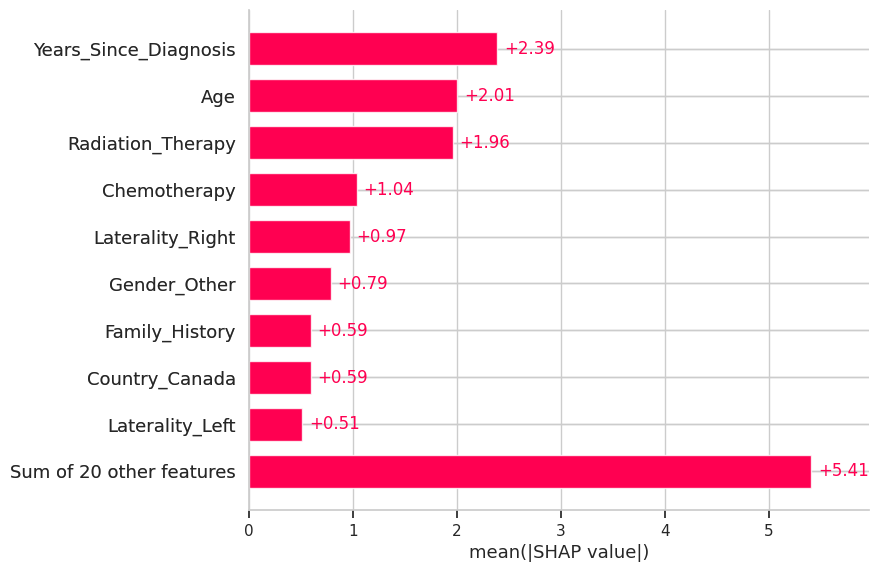

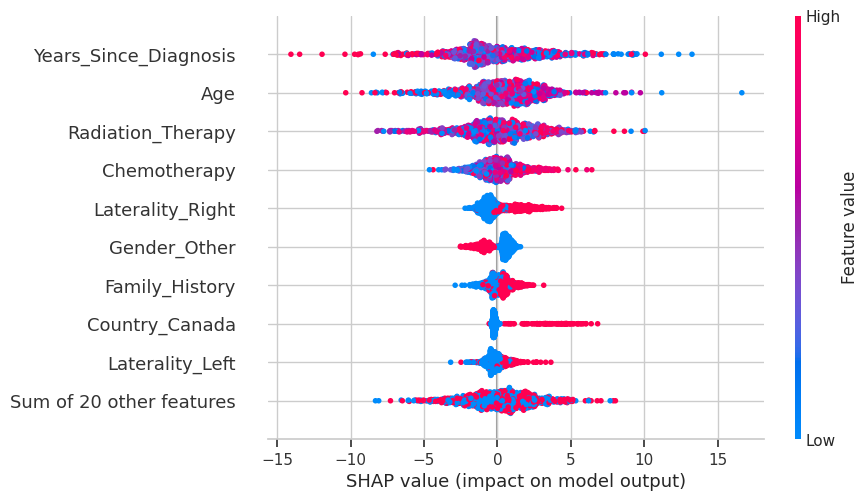

In [7]:
explainer = shap.Explainer(xgb_model, X)

shap_values = explainer(X_test)

shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)


## 🧠 Eye Cancer Survival Estimator

This interactive tool allows you to simulate a patient with ocular cancer and estimate their expected survival time (in months) using a machine learning model trained on clinical data.  

You can enter values such as age, treatment history, and time since diagnosis. The system will generate a personalized survival prediction and explain the key factors influencing the outcome using SHAP values.

⚠️ **Note**: This model is predictive, not causal. It reflects patterns in historical data, not medical advice.


In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output

idade = widgets.IntText(description='Idade:', value=50)
quimio = widgets.IntText(description='Ciclos de Quimio:', value=20)
anos_diagnostico = widgets.FloatText(description='Anos desde Dx:', value=2.5)

cirurgia = widgets.Checkbox(description='Fez Cirurgia?', value=True)
radiacao = widgets.Checkbox(description='Fez Radioterapia?', value=False)
historico = widgets.Checkbox(description='Hist. Familiar?', value=True)

botao = widgets.Button(description='Prever Sobrevida', button_style='success')
saida = widgets.Output()

def ao_clicar(b):
    with saida:
        clear_output()

        nova_entrada = X.iloc[0:1].copy()
        nova_entrada[:] = 0  # zera tudo

        nova_entrada['Age'] = idade.value
        nova_entrada['Chemotherapy'] = quimio.value
        nova_entrada['Surgery_Status'] = int(cirurgia.value)
        nova_entrada['Radiation_Therapy'] = int(radiacao.value)
        nova_entrada['Family_History'] = int(historico.value)
        nova_entrada['Years_Since_Diagnosis'] = anos_diagnostico.value

        pred = xgb_model.predict(nova_entrada)[0]
        print(f"Previsão de Sobrevida: {pred:.1f} meses")

        shap_values_single = explainer(nova_entrada)
        shap.plots.waterfall(shap_values_single[0])


botao.on_click(ao_clicar)

ui = widgets.VBox([
    idade, quimio, cirurgia, radiacao, historico, anos_diagnostico, botao, saida
])

display(ui)
